In [38]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec 

from astropy.io import fits
from astropy import units as u
from astropy import modeling
from astropy.table import Table

from astropy import modeling
from astropy import constants as cnst

## General Procedure
#### Overscan/Bias
#### Small Scale Flat
#### Combine exposures
#### Sky subtration
#### Extract Target Spectrum & collapse to 1D

How to use this pipeline for Dispersion Solution:

1. define ALL files to be used in reduction (see example for list)
2. set specset = dispersion fcn to use in guess_plot
3. use dispersion outputted graphs to estimate wl & pixel matches
4. use guess_plot to get linelist matches to refine pixel estimates 
5. collect ~5 of these in lists
6. use goodness_of_matches to populate more matches based on inital guesses & plot residuals
7. if satisfied, set ds = goodness_of_matches; this is the dispersion solution now

How to extract 1D Spectrum of Target---for each side!
1. define a targetID & skyaps
2. run sky_subtract and refine skyaps based on first graph produced
3. if satisfied set flux, unc = sky_subtract; this is the target's 1D flux spectrum for that side

How to combine red & blue sides to get one complete target spectrum
1. working on it

In [39]:
def guess_plot(pxguess, wlguess, specset, pxwindw=300, wlwindow=400): 
    fig, (ax1, ax2) = plt.subplots(1,2)

    ds, wlatlas, specatlas, linelist = specset 
    
    #use these graphs to refine matching of arcs to atlas
    
    #first graph 
    plt.axes(ax1)
    ds.plot_spec() #1D spectrum of dispersion solution or is this the arc..waiting on eriks answer
    plt.axvline(pxguess, color='k', ls=':') #plot a vertical line where think peak pixel is in emission lines
    plt.xlim(pxguess-pxwindw/2, pxguess+pxwindw/2)
    #plt.ylim(0, np.max(ds.spec1d[plt.xlim()[0] : plt.xlim()[1]])*1.05)
    plt.title('DS 1D Spectrum')

    
    #second graph
    plt.axes(ax2)
    plt.plot(wlatlas, specatlas) #plots what atlas spectrum looks like
    plt.title('Atlas 1D Spectrum')
    plt.axvline(wlguess, color='k', ls=':')
    plt.xlim(wlguess-wlwindow/2, wlguess+wlwindow/2)
    
    #defs the min & max wavelength peaks to use to scale in next lines
    minpx = np.argmin(np.abs(wlatlas-(wlguess-wlwindow/2)))
    maxpx = np.argmin(np.abs(wlatlas-(wlguess+wlwindow/2)))
    
  
    
    #sets wavelength scales based on graph size-ish
    plt.ylim(0, specatlas[minpx:maxpx].max()*1.05)
    guess = reduce_dblspec.nearest_in_line_list(wlguess, linelist)
    plt.axvline(guess[0], color='r', ls=':') #for 1st wavelength to linelist match draw red vertical line
    
    return guess #outputs wavelength guesses based on atlas spec known linelists

In [40]:
def dispersion(all_side_files,atlasfiles,arcfiles,linelist):
    #Overscan the flats
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #note above only works if all output headers include 'DomeFlat'
    
    #small scale flat creationg - normalized
    nfl = reduce_dblspec.create_normalized_flat(flats)

    header = atlasfiles[0].header    
    specnoao = atlasfiles[0].data
    wlnoao = header['CRVAL1'] + header['CD1_1']*(np.arange(len(specnoao)) - header['CRPIX1'] + 1) #+1 is for 0-based

    #creating dispersion solution
    ds = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(nfl), (320, 360))
    
    #print(header['IRAFNAME']) 
    
    #outputs graphs of atlas
    plt.figure(figsize=(20,5))
    plt.plot(wlnoao, specnoao)
    plt.title('Atlas 1D Spectrum-wavelengths')
    plt.xlabel('wavelengths')
    #atlas plot axis range limit choices
    if header['IRAFNAME']=='henear.spec': #redside
        #print('red') #tested & worked
        print('atlas plot limits for Red side')
        plt.xlim(5000,10000)
    if header['IRAFNAME']=='FeAr.spec': #blueside
        #print('blue') #tested & worked
        print('atlas plot limits for Blue side')
        plt.xlim(3000,5500)
        plt.ylim(0,5e5) #how to make this more flexible?
    else: #not sure why this prints for redside b/c its still choosing the correct xrange&blue does too
        print("can't determine camera side for atlas plot limits based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")    
    
    #outputting arc graph so can guess lines
    plt.figure(figsize=(20,5))
    plt.xlabel('pixels')
    plt.title('Arc Lamp 1D Spectrum-pixels')
    ds.plot_spec()
    #extra condition just for blue side orientation b/c of camera inversion to make comparison to atlas easier
    if header['IRAFNAME']=='FeAr.spec': #blueside
        plt.xlim([2800,0]) #for arc
    
    specset = (ds, wlnoao, specnoao,linelist)
    return (specset) #returns input for guess_plot along with graphs to make pixel & wl guesses

In [41]:
def goodness_of_matches(arcfiles, guesses,all_side_files, atlasfiles,linelist):
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #note above only works if all output headers include 'DomeFlat'
    #outputs = []
    #small scale flat creationg - normalized
    nfl = reduce_dblspec.create_normalized_flat(flats)
    header = atlasfiles[0].header    
    
    arcimg = reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(nfl)
    
    #print(header['IRAFNAME'])
    if header['IRAFNAME']=='henear.spec': #redside
        print('chose ds for redside')
        ds = reduce_dblspec.DispersionSolution(arcimg, (320, 360), poly_order=3)
        #print('ds for red')
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('chose ds for blueside')
        ds = reduce_dblspec.DispersionSolution(arcimg, (205, 260), poly_order=3)
    else:#for some reason this prints AS WELL AS prints indicating red side choosen for red side only, blue works fine
        print("camera side for ds not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")


    
    outputs = []
    for i in guesses:
            list_a = ds.guess_line_loc(i[0], i[1]) #guesses(pixel, wl)
            outputs.append(list_a) #why am i collecting these? where are they used?
            
    #print(header['IRAFNAME'])
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('chose guesses for blueside')
        ds.guess_from_line_list(linelist,minpeakratio=5, continuous_fit=True, sigmaclip=True, max_wl=5400)    
    if header['IRAFNAME']=='henear.spec': #redside
        print('chose guesses for redside')
        ds.guess_from_line_list(linelist,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=5600)
    else:
        print("camera side for guesses not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")
        #ds.guess_from_line_list(linelist,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=3000)
    



    #1st graph-residuals
    plt.figure(figsize=(20,5))
    residuals = ds.plot_solution(True)  
    #2nd graph-populated matches, px to wl;want linear 
    plt.figure(figsize=(20,5))
    ds.plot_spec_wl()
    
    return (ds) 

In [72]:
#skyaps=[(lower bound pixel location in (x,y), upper bound pixel location in (x,y))]
#play with vmax & vmin to get better contrast
def sky_subtract(targetID,skyaps,ds,all_side_files,atlasfiles):
    #need these again -flats/overscan
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    nfl = reduce_dblspec.create_normalized_flat(flats)
    
    header = atlasfiles[0].header    


    
    #locating all files w/ the target & flat/overscan subt
    specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files)]
    #stacking all that data for specific target-help increase s/n 
    comb = reduce_dblspec.combine_imgs(specs)
    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(20,10)) #setting up fig size
    subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0))
    plt.subplot(211)
    plt.title('2D spec - Verify skyaps for correct target extraction')
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 2D spec for blueside')
        subimg.show_image(transpose=True,vmax=40,vmin=-10)
    if header['IRAFNAME']=='henear.spec': #redside
        print('choose 2D spec for redside')
        subimg.show_image(transpose=False,vmax=40,vmin=-10) 
    else:
        print("camera side for 2D spec not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")    
    
    
    #setting up 1D extraction of target
    #setting up extraction range based on sky apps not sure if these is good to do b/c depends on extension of gal size
    begin = (skyaps[0][0] + 60)
    print ('this is beginning value of target spec extraction:',begin)
    end = (skyaps[1][0] - 30)
    print('this is end value of target spec extraction:',end)
    flux, unc = subimg.extract_spectrum((begin,end))
    
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    if header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])

    
    return (flux, unc)


Collecting problems to debug:
1. in sky_subtract 2D spec chooses correctly but ALSO prints else stmt --for blue side only
2. in goodness_of_matches ds chooses correctly but ALSO prints else stmt --for red side only
3. in dispersion atlas axis limits chooses correctly but ALSO prints else stmt --for red side only

Collecting questions:
1. in sky_subtract is using sky aps to base target extraction range a good idea in the interest of generalizing?
2. in sky_subtract y-axis meaning, flux/counts/units, get clarity.
3. why negative values in the 1D target spec after sky_subtract step?

# EXAMPLE: Red (1.5") -- dispersion solution
### Running data pipeline to generate graphs for wl & pixel  emission line matching

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


atlas plot limits for Red side
can't determine camera side for atlas plot limits based on: henear.spec


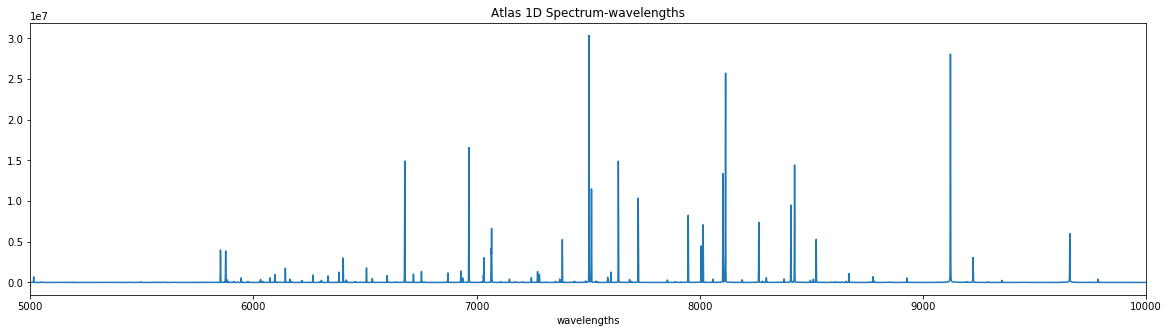

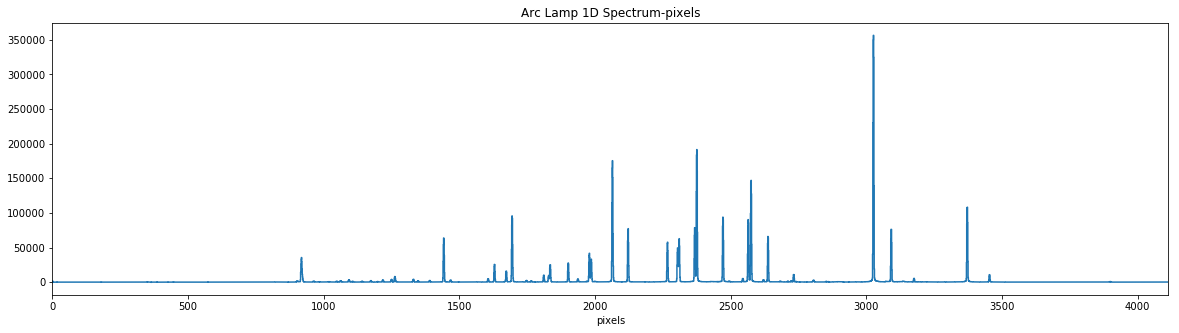

In [43]:
#running data pipeline to generate graphs for wl & pixel matching

#nameing all the datafiles needed
all_side_files_red15 = '20170518/red*.fits' #redside
atlasfiles_red15 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red15 = '20170518/red0017.fits' #redside
linelist_red15 = reduce_dblspec.HENEAR_LINE_LIST #must be in this form cant use'henearhres.dat'-debug later

#naming pipeline output for guess_plot use
specset_red15 = dispersion(all_side_files_red15, atlasfiles_red15, arcfiles_red15, linelist_red15)

### Collecting guesses from graphs above - manual intervention part

(9122.9673999999995, '9122.9674    ArI')

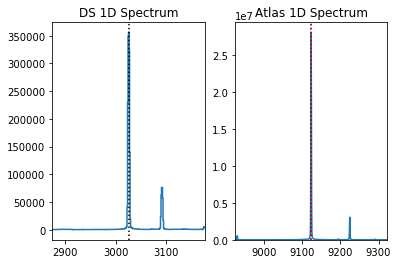

In [44]:
#guessing matching lines from above graphs
#entering (px,wl)guesses & data
guess_plot(3025.5,9122.9674,specset_red15) #outputs (pixel guess, nearest wl/id in linelist)

In [45]:
#collect guesses here ~5 seems good
pixel_guesses_red15 = [3372,3027,2375,2065,1630]
atlas_lines_red15 = [9657.78,9122.9674,8115.31,7635.1,6965.43]

guesses_red15 = list(zip(pixel_guesses_red15, atlas_lines_red15)) #making tuples to pass into fcn later

### Using goodness_of_matches to generate residuals and more line matches based on guesses above

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
camera side for ds not understood based on: henear.spec
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=347

Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 0.8644155931496915, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 0.9941144590061228, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Guessed line's peak to base ratio is 1.0229280821470732, which is less than 10"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to base ratio is 4.148138032795113, which is less than 10"
Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 3.3988140467662045, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Guessed line's peak to base ratio is 0.9784268022083137, which is less than 10"
Found line ArI at wl=8103.6931
Clipped 0 lines
Found line ArI at wl=8115.311
Clipped 0 lines
Failed to find line KrI at wl=8190.0543: "Tried to find peak at 2422.9794134689537 but it's in a valley, not a peak"
Found line Ar

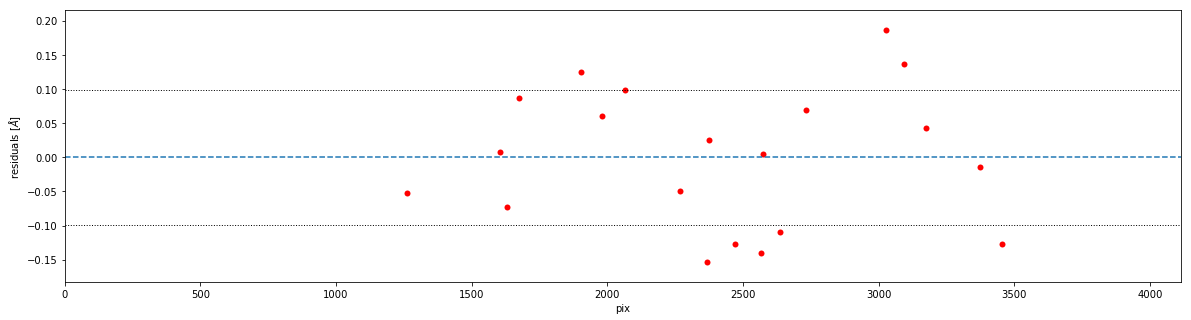

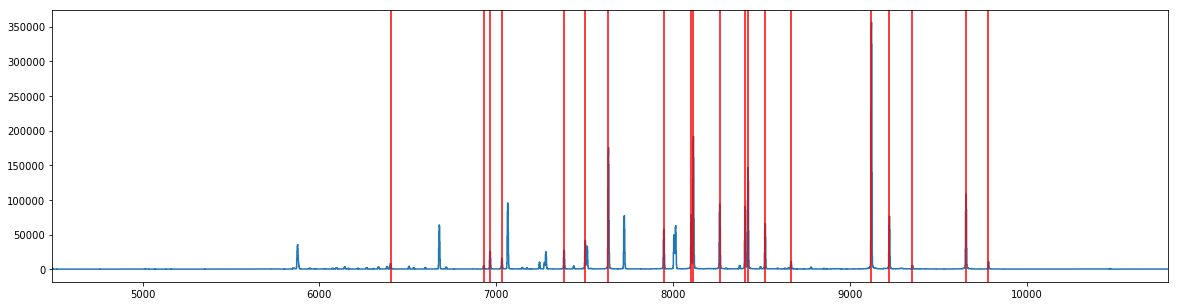

In [46]:
ds_red15 = goodness_of_matches(arcfiles_red15,guesses_red15,all_side_files_red15,atlasfiles_red15,linelist_red15)

# Red (1.0") --dispersion solution

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


atlas plot limits for Red side
can't determine camera side for atlas plot limits based on: henear.spec


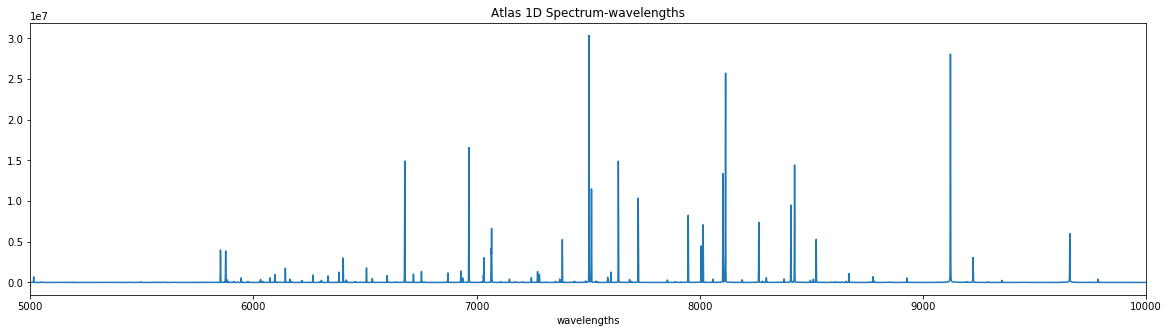

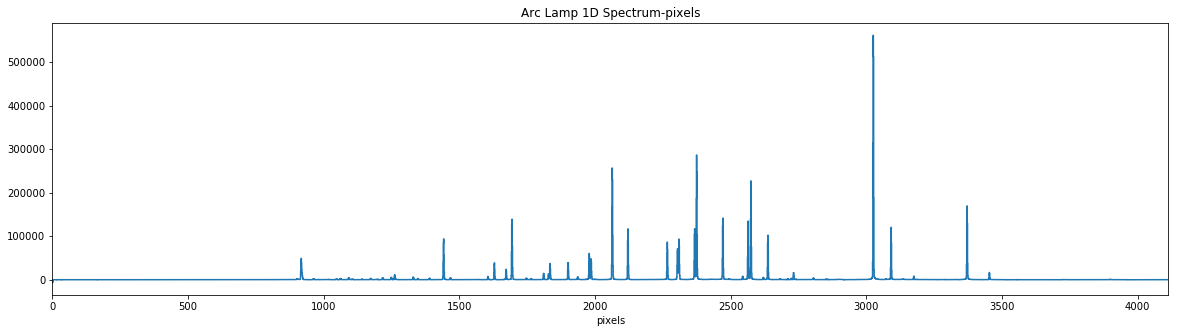

In [47]:
#nameing all the datafiles needed
all_side_files_red10 = '20170518/red*.fits' #redside
atlasfiles_red10 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red10 = '20170518/red0012.fits' #redside
linelist_red10 = reduce_dblspec.HENEAR_LINE_LIST

specset_red10 = dispersion(all_side_files_red10, atlasfiles_red10, arcfiles_red10, linelist_red10)

(9657.7862999999998, '9657.7863    ArI')

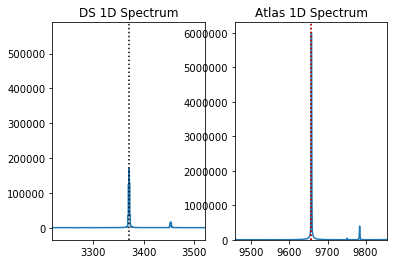

In [48]:
#guessing matching lines from above graphs
#entering (px,wl)guesses & data
guess_plot(3370,9657,specset_red10) #outputs (pixel guess, nearest wl/id in linelist)

In [49]:
#collect guesses here ~5 seems good
pixel_guesses_red10 = [3024,2373,2062,1672,3370]
atlas_lines_red10 = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]

guesses_red10 = list(zip(pixel_guesses_red10, atlas_lines_red10)) #making tuples to pass into fcn later

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
camera side for ds not understood based on: henear.spec
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=347

Failed to find line ArI at wl=7272.9359: "Guessed line's peak to base ratio is 7.605442276448056, which is less than 10"
Found line HeI at wl=7281.349
Clipped 0 lines
Failed to find line ArI at wl=7353.293: "Guessed line's peak to base ratio is 1.440416352893276, which is less than 10"
Failed to find line ArI at wl=7372.1184: "Guessed line's peak to base ratio is 1.886015039320914, which is less than 10"
Found line ArI at wl=7383.9805
Clipped 0 lines
Failed to find line NeI at wl=7488.8712: "Guessed line's peak to base ratio is 2.4296461377363423, which is less than 10"
Found line ArI at wl=7503.8691
Clipped 0 lines
Found line ArI at wl=7514.6518
Clipped 0 lines
Failed to find line NeI at wl=7535.7739: "Guessed line's peak to base ratio is 2.480156090889031, which is less than 10"
Failed to find line NeI at wl=7544.0443: "Guessed line's peak to base ratio is 1.2925552080633658, which is less than 10"
Failed to find line KrI at wl=7587.413: "Guessed line's peak to base ratio is 1.081955

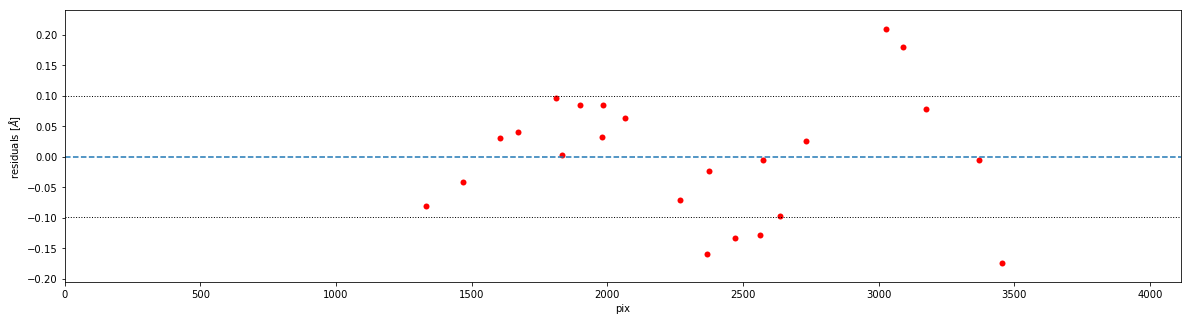

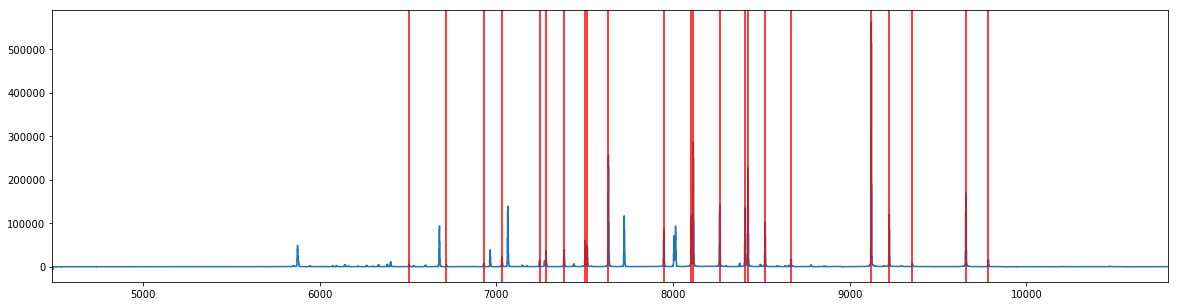

In [50]:
ds_red10 = goodness_of_matches(arcfiles_red10,guesses_red10,all_side_files_red10,atlasfiles_red10,linelist_red10)

# Blue (1.5") --dispersion solution

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


atlas plot limits for Blue side
not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...
b/c when use guess plot it appears in original orientation (which can be confusing at first)


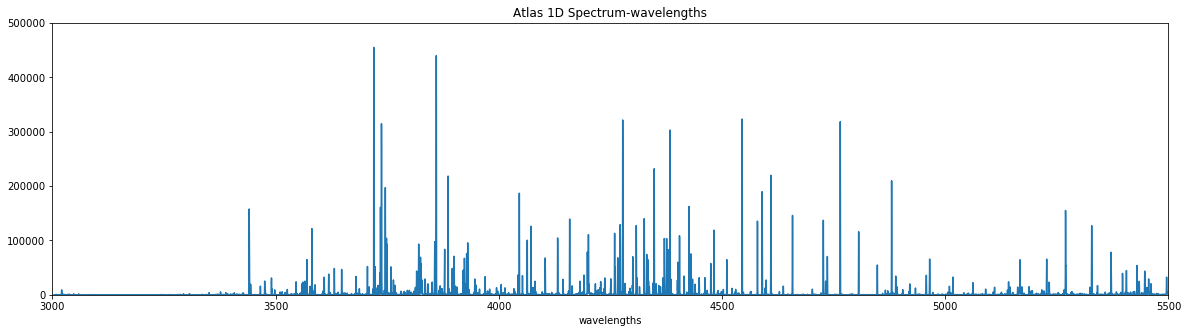

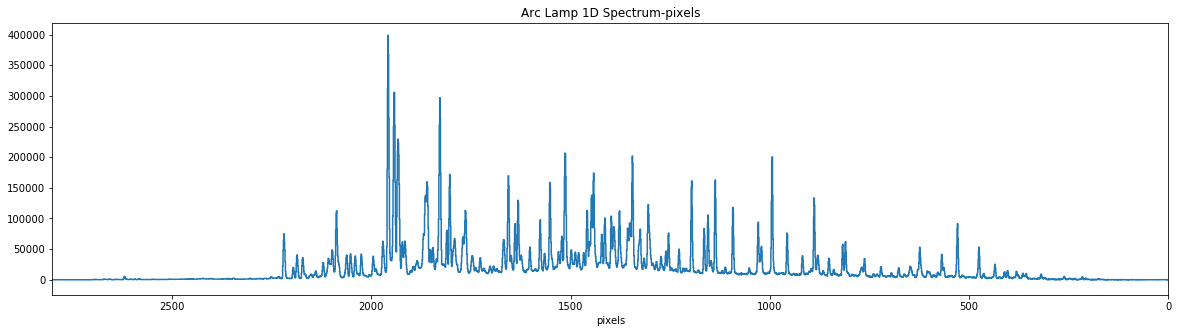

In [51]:
all_side_files_blue15 = '20170518/blue*.fits' #blueside
atlasfiles_blue15 = fits.open('fear.fits') #NOAO atlas #blueside
arcfiles_blue15 = '20170518/blue0018.fits' #blueside
linelist_blue15 = reduce_dblspec.FEAR_LINE_LIST #must be in this form cant use'fear.dat'--debug later

specset_blue15 = dispersion(all_side_files_blue15, atlasfiles_blue15, arcfiles_blue15, linelist_blue15)


print ('not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...''\n'
       'b/c when use guess plot it appears in original orientation (which can be confusing at first)')

(3581.1925000000001, '3581.1925  FeI')

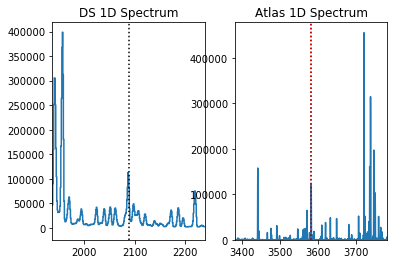

In [52]:
guess_plot(2088,3581,specset_blue15) #(px,wl)

In [53]:
#collect guesses here
pixel_guesses_blue15 = [1957,994,1655,1344,529] #1655,1344,1512,
atlas_lines_blue15 = [3719.9346,4764.8646,4044.4179,4383.5445,5266.5546] #4044.4179,4383.5445,4200.6745,

guesses_blue15 = list(zip(pixel_guesses_blue15, atlas_lines_blue15)) #making tuples to pass into fcn later

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Tried to find peak at 2631.9185486670676 but it's in a valley, not a peak"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 1.6375893971082662, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Tried to find peak at 2615.2006621433716 but it's in a valley, not a peak"
Failed to find line FeI at wl=3047.6043: "Guessed line's peak to base ratio is 1.716328296062425, which is less than 5"
Failed to find line FeI at wl=3057.4456: "Guessed line's peak to base ratio is 2.509572640659538, which is less than 5"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 2.509572640659538, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.1420168795452228, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 0.9938121748236681, which is less th

Failed to find line FeI at wl=3930.2962: "Guessed line's peak to base ratio is 2.4573917077839487, which is less than 5"
Failed to find line ArII at wl=3946.0971: "Guessed line's peak to base ratio is 2.9612340178890193, which is less than 5"
Failed to find line ArI at wl=3948.9789: "Guessed line's peak to base ratio is 2.9612340178890193, which is less than 5"
Failed to find line FeI at wl=3969.257: "Guessed line's peak to base ratio is 3.0855129661199157, which is less than 5"
Failed to find line ArII at wl=3979.3559: "Guessed line's peak to base ratio is 1.510408904251333, which is less than 5"
Failed to find line ArII at wl=3994.7918: "Guessed line's peak to base ratio is 2.4564854683248716, which is less than 5"
Failed to find line FeI at wl=4005.2414: "Guessed line's peak to base ratio is 2.333333336877587, which is less than 5"
Failed to find line ArII at wl=4033.8093: "Guessed line's peak to base ratio is 3.3812548441217003, which is less than 5"
Found line ArII at wl=4042.8937

Found line ArII at wl=4726.8683
Clipped 0 lines
Failed to find line ArII at wl=4732.0532: "Tried to find peak at 1024.8721134309487 but it's in a valley, not a peak"
Failed to find line ArII at wl=4735.9058: "Guessed line's peak to base ratio is 2.6965573932394564, which is less than 5"
Found line ArII at wl=4764.8646
Clipped 0 lines
Found line ArII at wl=4806.0205
Clipped 0 lines
Found line ArII at wl=4847.8095
Clipped 0 lines
Failed to find line FeI at wl=4859.7406: "Guessed line's peak to base ratio is 1.5342458864362543, which is less than 5"
Found line ArII at wl=4879.8635
Clipped 0 lines
Failed to find line ArII at wl=4889.0422: "Guessed line's peak to base ratio is 3.1960434069836063, which is less than 5"
Failed to find line FeI at wl=4891.4919: "Guessed line's peak to base ratio is 3.1960434069836063, which is less than 5"
Failed to find line FeI at wl=4920.5018: "Guessed line's peak to base ratio is 4.554165053396049, which is less than 5"
Failed to find line ArII at wl=4933.

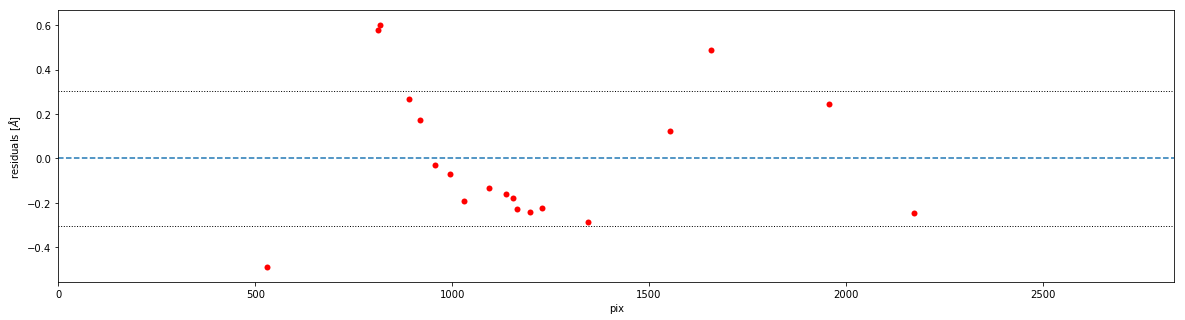

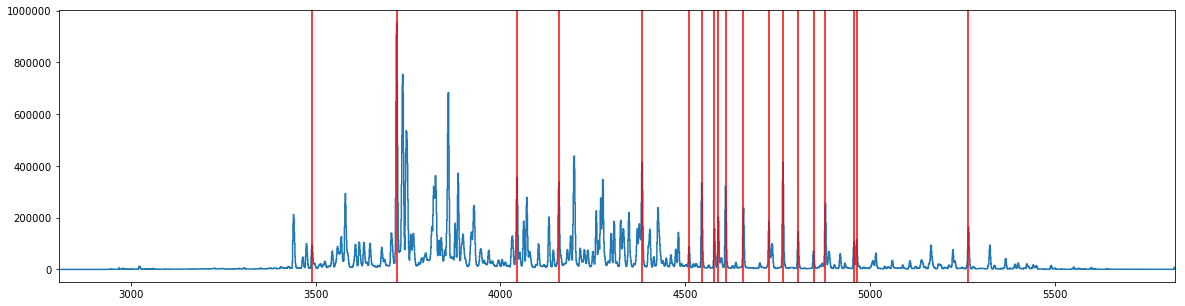

In [54]:
ds_blue15 = goodness_of_matches(arcfiles_blue15,guesses_blue15,all_side_files_blue15,atlasfiles_blue15,linelist_blue15) #yay looks good FINALLY!!
#makes sense these residuals are worse b/c just tried same guesses used for 1.0" SOOOO ds for 1.0 & 1.5 are different!


# Blue (1.0") --dispersion solution

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


atlas plot limits for Blue side
not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...
b/c when use guess plot it appears in original orientation (which can be confusing at first)


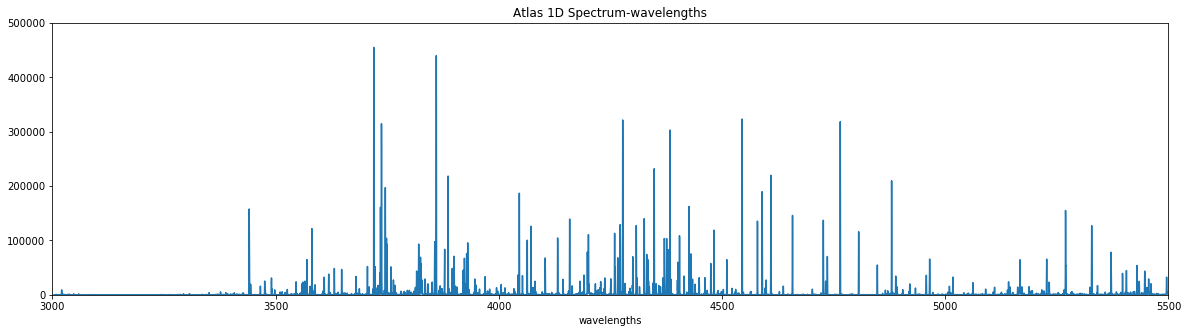

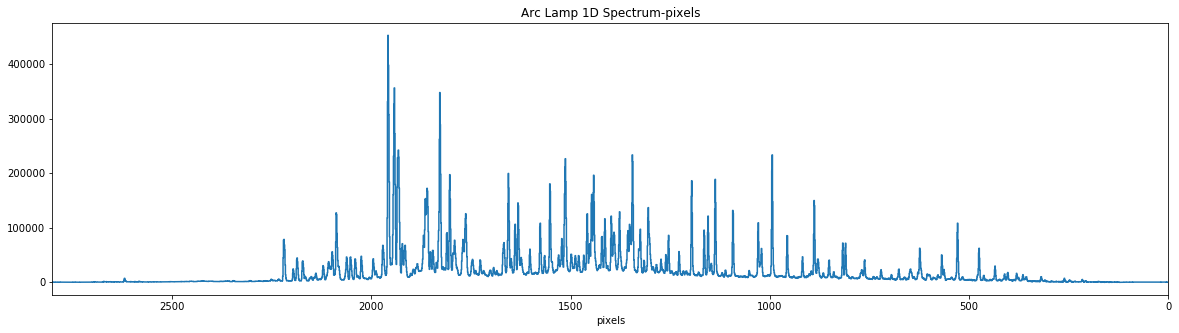

In [55]:
all_side_files_blue10 = '20170518/blue*.fits' #blueside
atlasfiles_blue10 = fits.open('fear.fits') #NOAO atlas #blueside
arcfiles_blue10 = '20170518/blue0011.fits' #blueside
linelist_blue10 = reduce_dblspec.FEAR_LINE_LIST #must be in this form cant use'fear.dat'--debug later

specset_blue10 = dispersion(all_side_files_blue10, atlasfiles_blue10, arcfiles_blue10, linelist_blue10)


print ('not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...''\n'
       'b/c when use guess plot it appears in original orientation (which can be confusing at first)')

(3581.1925000000001, '3581.1925  FeI')

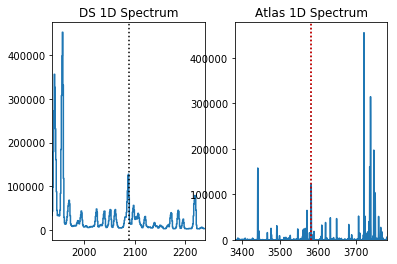

In [56]:
guess_plot(2088,3581,specset_blue10) #(px,wl)

In [57]:
#collect guesses here

pixel_guesses_blue10 = [1958,993,529,1602,1550,1254] #2088,
atlas_lines_blue10 = [3719.9346,4764.8646,5266.5546,4103.91,4158.59,4481.81] #3581.1925,
##all the commented out values either didnt allow convergence or had peak/base ratios less than 3

#these were eriks guesses....i tried different values to test method, got same results yay!
##pixel_guesses_blue10 = [1957,994,1655,1344,529] #1655,1344,1512,
##atlas_lines_blue10 = [3719.9346,4764.8646,4044.4179,4383.5445,5266.5546] #4044.4179,4383.5445,4200.6745,


guesses_blue10 = list(zip(pixel_guesses_blue10, atlas_lines_blue10)) #making tuples to pass into fcn later

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Tried to find peak at 2622.141126221478 but it's in a valley, not a peak"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 3.884537599063041, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 0.9729875346430994, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Tried to find peak at 2595.9102217545324 but it's in a valley, not a peak"
Failed to find line FeI at wl=3057.4456: "Tried to find peak at 2586.3520807703403 but it's in a valley, not a peak"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 2.728611272165076, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.2953062119576328, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.2666965744164804, which is less than 5

Failed to find line ArII at wl=3925.7188: "Guessed line's peak to base ratio is 2.3168355687893114, which is less than 5"
Failed to find line FeI at wl=3930.2962: "Guessed line's peak to base ratio is 2.3168355687893114, which is less than 5"
Failed to find line ArII at wl=3946.0971: "Guessed line's peak to base ratio is 2.6304219944069844, which is less than 5"
Failed to find line ArI at wl=3948.9789: "Guessed line's peak to base ratio is 2.6304219944069844, which is less than 5"
Failed to find line FeI at wl=3969.257: "Guessed line's peak to base ratio is 3.361028866764175, which is less than 5"
Failed to find line ArII at wl=3979.3559: "Guessed line's peak to base ratio is 1.6280945381500822, which is less than 5"
Failed to find line ArII at wl=3994.7918: "Guessed line's peak to base ratio is 2.2990012002387603, which is less than 5"
Failed to find line FeI at wl=4005.2414: "Guessed line's peak to base ratio is 2.571218523673293, which is less than 5"
Failed to find line ArII at wl=

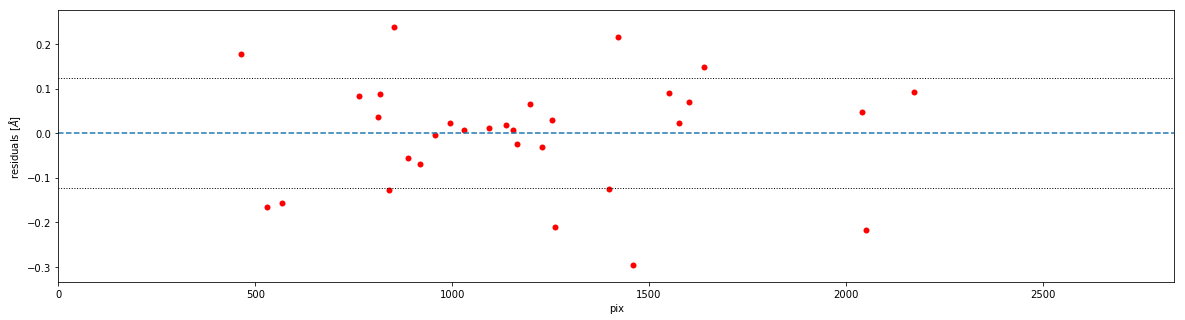

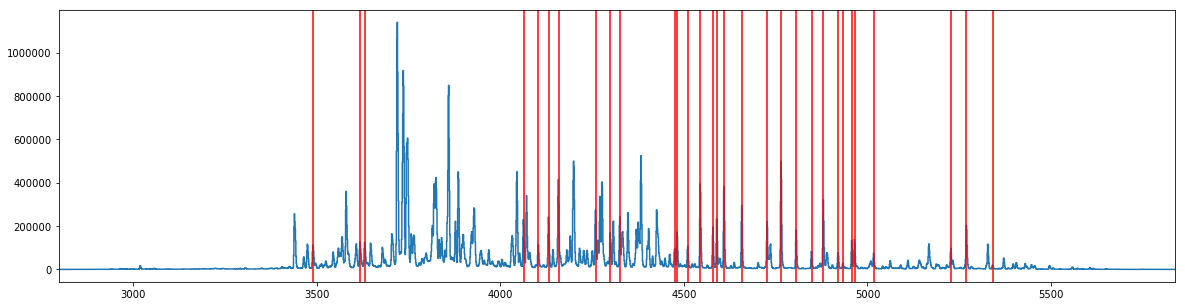

In [58]:
ds_blue10 = goodness_of_matches(arcfiles_blue10,guesses_blue10,all_side_files_blue10,atlasfiles_blue10,linelist_blue10) #yay looks good FINALLY!!
#used some guesses diff from Erik's nb BUT soln looks the same 

# Trying a Sky Subtraction on Target

### Blue (1.0") skysubtract

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


choose 2D spec for blueside
camera side for 2D spec not understood based on: FeAr.spec
this is beginning value of target spec extraction: 324
this is end value of target spec extraction: 110
choose 1D target spec axis limits for blueside
why is there negative??


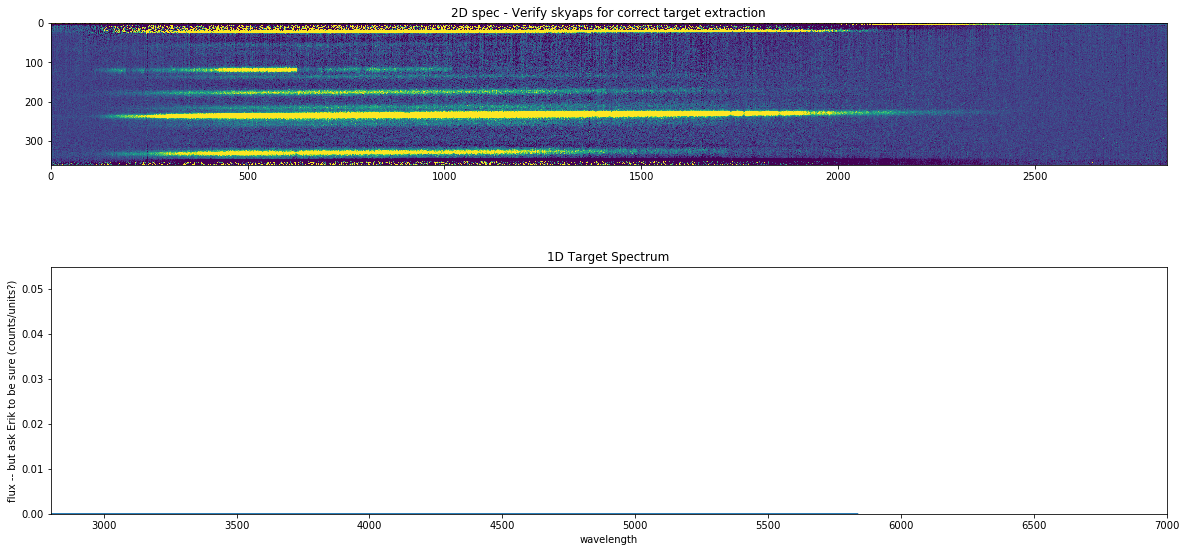

In [84]:
#naming files needed

#this one has more than one image tho....how to deal with? or do i have to? - non-SAGA
targetID_blue10 = 'M-01-04' #PROBLEM THIS TARGET ISNT IN 1.0" ONLY 1.5"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
skyaps_blue10 = [(264,300), (140, 155)]#sky aperatures-part to subtract sky lines from in spatial direction 
#skyaps == A list of 2-tuples (lower, upper) or slices, specifying the sections along the spatial direction to define the sky.
#aka sections above & below target spec to base subtraction on

#(15,80),(150,215) #old skyaps
#(264,300), (140, 155) #eriks skyaps

flux_blue10, unc = sky_subtract(targetID_blue10,skyaps_blue10,ds_blue10,all_side_files_blue10,atlasfiles_blue10)

print('why is there negative??')

### Red (1.0") skysubtract

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


choose 2D spec for redside
this is beginning value of target spec extraction: 340
this is end value of target spec extraction: 350
choose 1D target spec axis limits for redside


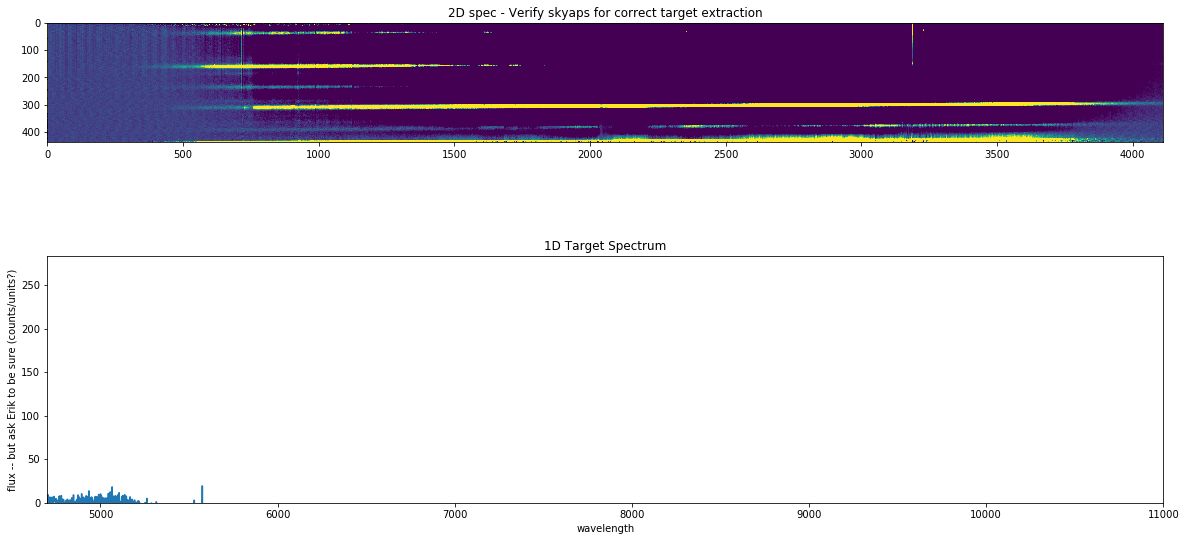

In [82]:
#naming files needed
targetID_red10 = 'M-01-04' #input name of target that uses 1.0"
skyaps_red10 = [(280,310),(380,410)]#sky aperatures-part to subtract sky lines from in spatial direction 

#(15,80),(150,215) #good for blue side
#(280,310),(380,410) #good for red side

flux_red10, unc = sky_subtract(targetID_red10,skyaps_red10,ds_red10,all_side_files_red10,atlasfiles_red10)

###  Red (1.5") skysubtract

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


choose 2D spec for redside
this is beginning value of target spec extraction: 340
this is end value of target spec extraction: 350
choose 1D target spec axis limits for redside


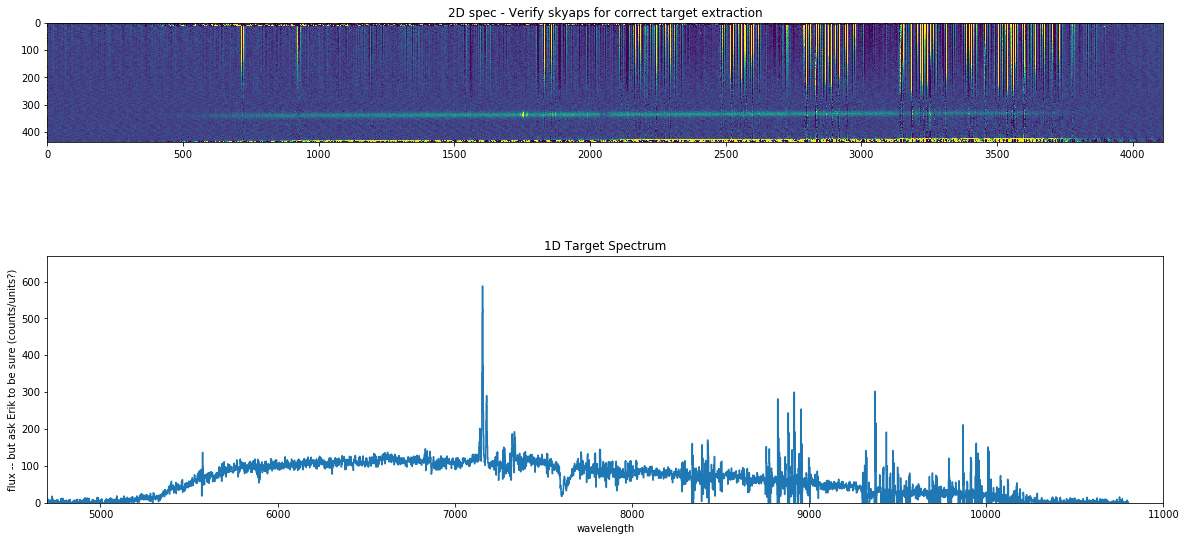

In [74]:
#naming files needed
targetID_red15 = 'Ody_nospec'
skyaps_red15 = [(280,310),(380,410)]

flux_red15,unc = sky_subtract(targetID_red15,skyaps_red15,ds_red15,all_side_files_red15,atlasfiles_red15)

shape looks similar but ymax is ~1/2 of eriks graph


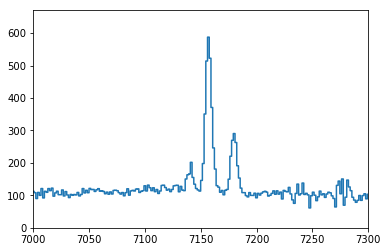

In [75]:
#zooming in on a peak to see if similar to eriks

wl = ds_red15.pixtowl(np.arange(len(flux_red15)))
plt.step(wl, flux_red15)
plt.xlim(7000, 7300)
plt.ylim(0, plt.ylim()[-1])
print('shape looks similar but ymax is ~1/2 of eriks graph')

### Blue (1.5") skysubtract

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


choose 2D spec for blueside
camera side for 2D spec not understood based on: FeAr.spec
this is beginning value of target spec extraction: 75
this is end value of target spec extraction: 120
choose 1D target spec axis limits for blueside
why is there negative??


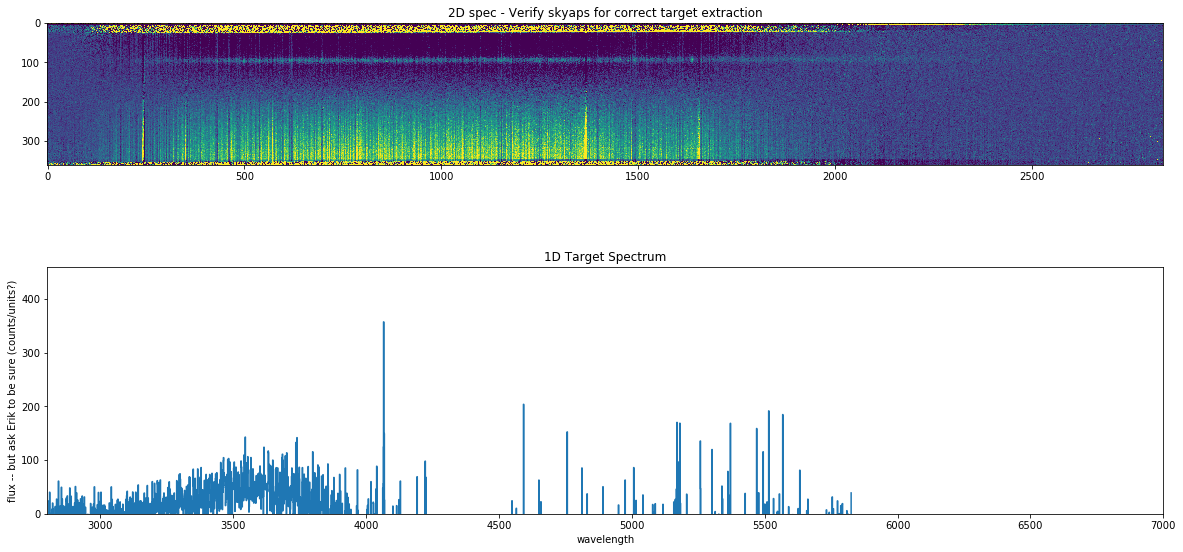

In [103]:
#naming files needed
targetID_blue15 = 'Ody_nospec'
skyaps_blue15 = [(15,80),(150,215)]

flux_blue15,unc_blue15 = sky_subtract(targetID_blue15,skyaps_blue15,ds_blue15,all_side_files_blue15,atlasfiles_blue15)

print('why is there negative??')

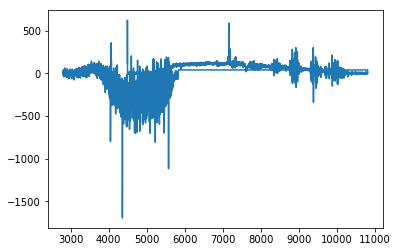

In [95]:
wl = np.append(ds_red15.pixtowl(np.arange(len(flux_red15))), ds_blue15.pixtowl(np.arange(len(flux_blue15))))
red_and_blue_flux = np.append(flux_red15,flux_blue15)
plt.step(wl, red_and_blue_flux)
#plt.xlim(7000, 7300)
#plt.ylim(0, plt.ylim()[-1])
print('red side looks crazy! BUT this is a complete/combined wavelength range 1D spectrum for target')

#testing
#print('red',len(flux_red15))
#print('blue', len(flux_blue15))
#print('rb:',len(red_and_blue_flux))

#wl_rb = np.append(ds_red15.pixtowl(np.arange(len(flux_red15))), ds_blue15.pixtowl(np.arange(len(flux_blue15))))
#print('red',len(ds_red15.pixtowl(np.arange(len(flux_red15)))))
#print('blue', len(ds_blue15.pixtowl(np.arange(len(flux_blue15)))))
#print('rb:',len(wl_rb))

In [112]:
def combine_red_blue(ds_red,ds_blue,flux_red,flux_blue):
    wl = np.append(ds_red.pixtowl(np.arange(len(flux_red))), ds_blue.pixtowl(np.arange(len(flux_blue))))
    red_and_blue_flux = np.append(flux_red,flux_blue)
    plt.step(wl, red_and_blue_flux)
    plt.xlabel('wavelength')
    plt.ylabel('?? flux??')
    plt.title('1D Spectrum for Target')
    plt.ylim(0, max(red_and_blue_flux))
    return(red_and_blue_flux)


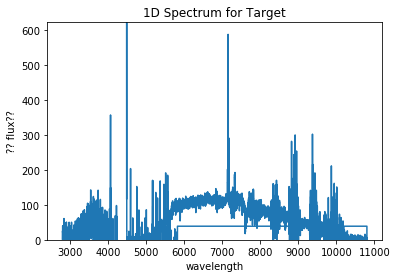

In [113]:
rb_flux = combine_red_blue(ds_red15,ds_blue15,flux_red15,flux_blue15)